In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install datasets pillow tqdm
from datasets import load_from_disk

# Load the train, validation, and testval splits
train_dataset = load_from_disk('/content/drive/MyDrive/nsd_data/algonauts_2023/processed/size-256/train')
val_dataset = load_from_disk('/content/drive/MyDrive/nsd_data/algonauts_2023/processed/size-256/val')
testval_dataset = load_from_disk('/content/drive/MyDrive/nsd_data/algonauts_2023/processed/size-256/testval')

print(train_dataset)
print(train_dataset[0])


In [ ]:
!pip install transformers
import torch
import torch.nn as nn
from transformers import ViTModel

class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()

        # ViT Encoder
        self.encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.latent_dim = latent_dim

        # Fully connected layers for latent space
        self.fc_mu = nn.Linear(self.encoder.config.hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder.config.hidden_size, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 512 * 7 * 7)

        # Decoder
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # 7x7 -> 14x14
          nn.ReLU(),
          nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 14x14 -> 28x28
          nn.ReLU(),
          nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28 -> 56x56
          nn.ReLU(),
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # 56x56 -> 112x112
          nn.ReLU(),
          nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # 112x112 -> 224x224
          nn.Sigmoid()
)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder: ViT
        vit_outputs = self.encoder(x, output_hidden_states=False)
        hidden_states = vit_outputs.last_hidden_state[:, 0]  # Use CLS token

        # Latent space
        mu = self.fc_mu(hidden_states)
        logvar = self.fc_logvar(hidden_states)
        z = self.reparameterize(mu, logvar)

        # Decoder
        recon = self.decoder_input(z)
        recon = recon.view(-1, 512, 7, 7)
        recon = self.decoder(recon)
        return recon, mu, logvar


In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Custom PyTorch Dataset
class FMRIImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        activity = torch.tensor(sample['activity'], dtype=torch.float32)  # fMRI signal

        if self.transform:
            image = self.transform(image)

        return image, activity

# Wrap dataset with PyTorch
train_data = FMRIImageDataset(train_dataset, transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)


NEW METHOD

In [ ]:
!pip install datasets pillow tqdm transformers

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_from_disk
from transformers import ViTModel
import torch.nn.functional as F

# Load datasets
train_dataset = load_from_disk('/content/drive/MyDrive/nsd_data/algonauts_2023/processed/size-256/train')
val_dataset = load_from_disk('/content/drive/MyDrive/nsd_data/algonauts_2023/processed/size-256/val')
testval_dataset = load_from_disk('/content/drive/MyDrive/nsd_data/algonauts_2023/processed/size-256/testval')

print(train_dataset)
print(train_dataset[0])
fmri_example = train_dataset[0]['activity']
fmri_dim = len(fmri_example)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class FMRIImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        activity = torch.tensor(sample['activity'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        return image, activity

train_data = FMRIImageDataset(train_dataset, transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

class VAE(nn.Module):
    def __init__(self, latent_dim=256, fmri_dim=None):
        super(VAE, self).__init__()
        if fmri_dim is None:
            raise ValueError("fmri_dim must be specified")

        # ViT Encoder
        self.encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.latent_dim = latent_dim

        # For image-derived latent
        self.fc_mu = nn.Linear(self.encoder.config.hidden_size, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder.config.hidden_size, latent_dim)

        # For fMRI-derived latent (fMRI -> latent)
        self.fmri_to_latent = nn.Sequential(
            nn.Linear(fmri_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

        # For latent-derived fMRI (latent -> fMRI)
        self.latent_to_fmri = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, fmri_dim)
        )

        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 512 * 7 * 7)

        # Decoder to reconstruct image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode_image(self, x):
        vit_outputs = self.encoder(x, output_hidden_states=False)
        hidden_states = vit_outputs.last_hidden_state[:, 0]
        mu = self.fc_mu(hidden_states)
        logvar = self.fc_logvar(hidden_states)
        z_img = self.reparameterize(mu, logvar)
        return z_img, mu, logvar

    def encode_fmri(self, activity):
        return self.fmri_to_latent(activity)

    def decode(self, z):
        recon = self.decoder_input(z)
        recon = recon.view(-1, 512, 7, 7)
        recon = self.decoder(recon)
        return recon

    def forward(self, x, activity):
        # Image -> latent
        z_img, mu, logvar = self.encode_image(x)
        # fMRI -> latent
        z_fmri = self.encode_fmri(activity)
        # latent -> image
        recon = self.decode(z_img)
        # latent -> fMRI
        fmri_pred = self.latent_to_fmri(z_img)
        return recon, mu, logvar, z_img, z_fmri, fmri_pred

def loss_function(recon_x, x, mu, logvar, z_img, z_fmri, fmri_pred, fmri_gt, lambda_fmri=1.0, lambda_fmri_recon=1.0):
    # Image reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Latent alignment loss: ensure z_img ~ z_fmri
    fmri_latent_loss = F.mse_loss(z_img, z_fmri, reduction='sum')

    # fMRI reconstruction loss: ensure fmri_pred ~ fmri_gt (from image)
    fmri_recon_loss = F.mse_loss(fmri_pred, fmri_gt, reduction='sum')

    return recon_loss + kld_loss + lambda_fmri * fmri_latent_loss + lambda_fmri_recon * fmri_recon_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=256, fmri_dim=fmri_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

save_path = '/content/drive/MyDrive/vae_model_fmri'
os.makedirs(save_path, exist_ok=True)

Dataset({
    features: ['split', 'subject', 'subject_id', 'sample_id', 'nsd_id', 'image', 'activity'],
    num_rows: 24450
})
{'split': 'train', 'subject': 'subj01', 'subject_id': 0, 'sample_id': 1352, 'nsd_id': 10459, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x78395583A1A0>, 'activity': [-0.6802130937576294, -0.03223996236920357, -0.28753116726875305, -1.3810890913009644, -0.8335912227630615, -0.9322627782821655, -0.24177655577659607, -0.21463702619075775, 0.1585964858531952, 0.18870893120765686, 0.6244354248046875, 1.6187149286270142, -0.698640763759613, -0.4649065434932709, -1.1286858320236206, -1.2322875261306763, -0.6444418430328369, 0.8209864497184753, -0.5930544137954712, -0.629973292350769, 0.3073829114437103, -0.7263011336326599, -1.1012169122695923, 0.3777778744697571, -0.18045669794082642, -0.2009589821100235, -0.8423824310302734, 0.0539160817861557, -1.6119840145111084, -1.8683416843414307, 0.17024774849414825, -0.6863701343536377, -0.256861

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-5-5d2c245c9f30>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_file, map_location=device))


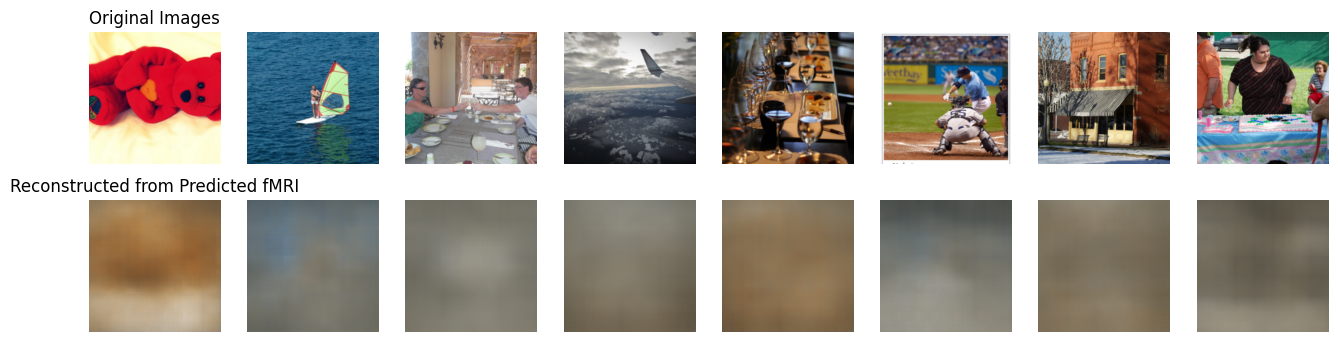

In [ ]:
import torch
import os
import matplotlib.pyplot as plt

save_path = '/content/drive/MyDrive/vae_model_fmri'
model_file = os.path.join(save_path, 'vae_epoch_5.pth')

fmri_dim = len(train_dataset[0]['activity'])
vae = VAE(latent_dim=256, fmri_dim=fmri_dim).to(device)
vae.load_state_dict(torch.load(model_file, map_location=device))
vae.eval()

images, activity = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    # Step 1: Encode image to get z_img, mu, logvar
    vit_outputs = vae.encoder(images, output_hidden_states=False)
    hidden_states = vit_outputs.last_hidden_state[:, 0]
    mu = vae.fc_mu(hidden_states)
    logvar = vae.fc_logvar(hidden_states)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z_img = mu + eps * std

    # Step 2: Predict fMRI from z_img
    fmri_pred = vae.latent_to_fmri(z_img)

    # Step 3: Map predicted fMRI back to latent (z_fmri_back)
    z_fmri_back = vae.fmri_to_latent(fmri_pred)

    # Step 4: Decode z_fmri_back to reconstruct the image
    recon_from_fmri = vae.decode(z_fmri_back)

# Move data back to CPU for visualization
images = images.cpu()
recon_from_fmri = torch.clamp(recon_from_fmri.cpu(), 0, 1)

# Visualization
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(images[i].permute(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_from_fmri[i].permute(1, 2, 0))
    axes[1, i].axis('off')

axes[0, 0].set_title('Original Images')
axes[1, 0].set_title('Reconstructed from Predicted fMRI')
plt.show()
